In [271]:
import numpy as np
import matplotlib.pyplot as plt

In [272]:
T = 1
NbMes = 100
SigmaMes = 1*np.pi/180

# observations
Phi = 135 * np.pi / 180
VitesseObservateur = 10
XObservateurInit = [0,0, VitesseObservateur, 0]

# emetteur
VitesseEmetteur = 5
CapEmetteur = - 20 * np.pi/180
XemetteurInit = np.array([2000, 2000, VitesseEmetteur*np.cos(CapEmetteur) , VitesseEmetteur*np.sin(CapEmetteur)])

# incertitude initiale
P0 = np.diag( [1000**2, 1000**2, 10**2, 10**2] )
JinfoInit = np.linalg.inv(P0)

In [273]:
PHI = np.identity(4)
PHI[0,2] = T
PHI[1,3] = T
PHI

array([[1., 0., 1., 0.],
       [0., 1., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [274]:
# observations
def init_X(NbMes, XemetteurInit, PHI):
    X = np.empty(NbMes, dtype=list)
    X[0] = XemetteurInit
    for k in range(1, NbMes) :
        X[k] = np.dot(PHI, X[k-1])
    return(X)

def init_Y(XObservateurInit, NbMes, VitesseObservateur, Phi):
    Y = np.empty(NbMes, dtype=np.ndarray)
    Y[0] = XObservateurInit
    for k in range(1, NbMes//2):
        Y[k] = [k  * VitesseObservateur, 0, VitesseObservateur, 0]
    n_vitesse = [VitesseObservateur * np.cos(Phi), VitesseObservateur * np.sin(Phi)]
    for k in range(NbMes//2, NbMes):
        Y[k] = [ VitesseObservateur * NbMes//2 + n_vitesse[0] * (k - NbMes//2), 
                n_vitesse[1] * (k - NbMes//2), 
                n_vitesse[0], n_vitesse[1]]
    return(Y)

In [275]:
Y = init_Y( XObservateurInit, NbMes, VitesseObservateur, Phi)
X = init_X(NbMes, XemetteurInit, PHI)

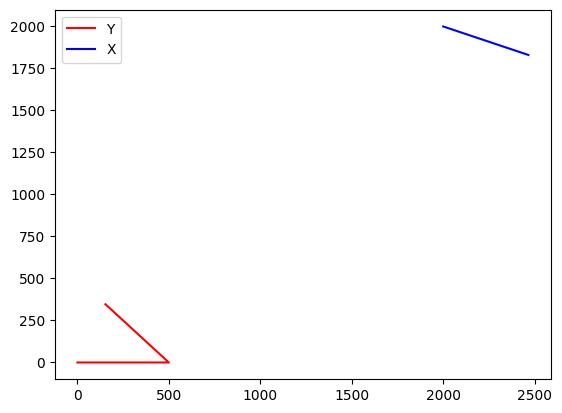

In [276]:
# affiche trajectoire Y
plt.plot([Y[k][0] for k in range(NbMes)], [Y[k][1] for k in range(NbMes)], 'r', label = 'Y')

# affiche trajectoire X
plt.plot([X[k][0] for k in range(NbMes)], [X[k][1] for k in range(NbMes)], 'b', label = 'X')
plt.legend()
plt.show()

In [277]:
# initialisation de J

def dhdX(pos_emetteur, pos_observateur):
    x_k, y_k = pos_emetteur
    x_k0, y_k0 = pos_observateur
    return(np.array([(y_k0- y_k)/ ((x_k-x_k0)**2 + (y_k-y_k0)**2), (x_k- x_k0)/ ((x_k-x_k0)**2 + (y_k-y_k0)**2), 0 , 0]))

def init_J(NbMes, JinfoInit, X, Y, PHI):
    J = np.empty(NbMes, dtype=np.ndarray)
    J[0] = JinfoInit
    for k in range(1, NbMes) :
        derivee = dhdX([X[k][0], X[k][1]], [Y[k][0], Y[k][1]])
        J[k] = 1/ SigmaMes**2 * np.dot(derivee.reshape(4,1), derivee.reshape(1,4)) + np.linalg.inv(PHI).T @ J[k-1] @ np.linalg.inv(PHI)
    return(J)

In [278]:
J = init_J(NbMes, JinfoInit, X, Y, PHI)

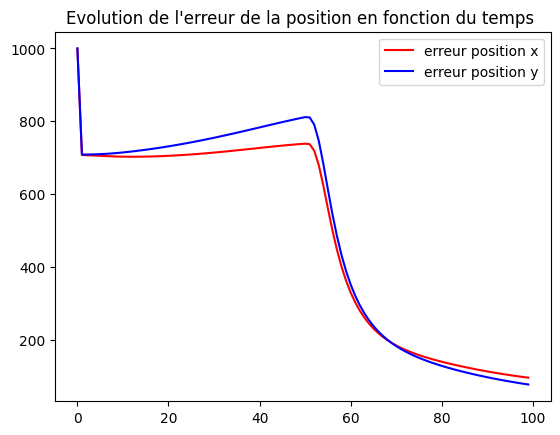

In [279]:
erreur_x = [np.sqrt(np.linalg.inv(J[k])[0,0]) for k in range(NbMes)]
erreur_y = [np.sqrt(np.linalg.inv(J[k])[1,1]) for k in range(NbMes)]

# on plto l'erreur
plt.plot(range(NbMes), erreur_x, 'r', label = 'erreur position x')
plt.plot(range(NbMes), erreur_y, 'b', label = 'erreur position y')
plt.legend()
plt.title(r"Evolution de l'erreur de la position en fonction du temps ")
plt.show()

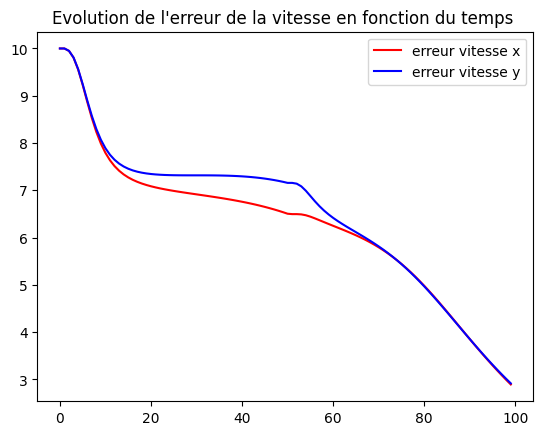

In [280]:
erreur_vitesse_x = [np.sqrt(np.linalg.inv(J[k])[2,2]) for k in range(NbMes)]
erreur_vitesse_y = [np.sqrt(np.linalg.inv(J[k])[3,3]) for k in range(NbMes)]

# on plto l'erreur
plt.plot(range(NbMes), erreur_vitesse_x, 'r', label = 'erreur vitesse x')
plt.plot(range(NbMes), erreur_vitesse_y, 'b', label = 'erreur vitesse y')
plt.legend()
plt.title(r"Evolution de l'erreur de la vitesse en fonction du temps ")
plt.show()

In [281]:
var_phi = np.linspace(0, 2 * np.pi, 100)

res_position = []
res_vitesse   = []
for phi in var_phi :
    Y = init_Y( XObservateurInit, NbMes, VitesseObservateur, phi)
    X = init_X(NbMes, XemetteurInit, PHI)
    J = init_J(NbMes, JinfoInit, X, Y, PHI)
    erreur_finale_position = np.sqrt(np.linalg.inv(J[NbMes-1])[0,0] + np.linalg.inv(J[NbMes-1])[1,1])
    res_position.append(erreur_finale_position)
    erreur_finale_vitesse = np.sqrt(np.linalg.inv(J[NbMes-1])[2,2] + np.linalg.inv(J[NbMes-1])[3,3])
    res_vitesse.append(erreur_finale_vitesse)
    

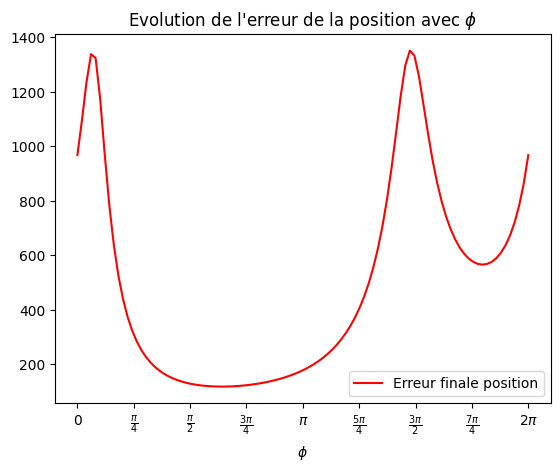

In [282]:
plt.plot(var_phi, res_position, 'r', label = 'Erreur finale position')
# change scale writting pi instead of 3.14
plt.xticks(np.arange(0, 2* np.pi+0.1, np.pi/4), ['0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$', r'$\frac{5\pi}{4}$',r'$\frac{3\pi}{2}$', r'$\frac{7\pi}{4}$',r'$2\pi$'])
plt.legend()
plt.xlabel(r'$\phi$')
plt.title(r"Evolution de l'erreur de la position avec $\phi$ ")
plt.show()

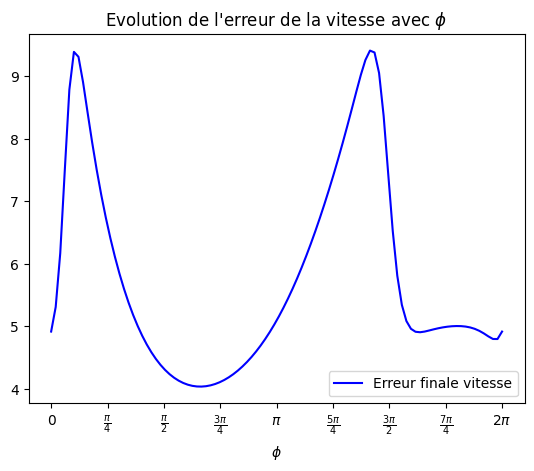

In [283]:
plt.plot(var_phi, res_vitesse, 'b', label = 'Erreur finale vitesse')
# change scale writting pi instead of 3.14
plt.xticks(np.arange(0, 2* np.pi+0.1, np.pi/4), ['0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$', r'$\frac{5\pi}{4}$',r'$\frac{3\pi}{2}$', r'$\frac{7\pi}{4}$',r'$2\pi$'])
plt.legend()
plt.xlabel(r'$\phi$')
plt.title(r"Evolution de l'erreur de la vitesse avec $\phi$ ")
plt.show()